In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
from sklearn.metrics import confusion_matrix
from transformers import TextClassificationPipeline

plt.style.use('ggplot')

In [ ]:
PATH = '/content/dataset_bng_labeled.csv'
df = pd.read_csv(PATH)
print("Shape : \n", "-"*10,"\n", df.shape)
print("\nNull Values : \n", "-"*10,"\n", df.isnull().sum())

Shape : 
 ---------- 
 (11807, 4)

Null Values : 
 ---------- 
 Sentiment         0
Text              0
Processed Text    0
labels            0
dtype: int64


In [ ]:
id2label = {
    0 : 'Negative',
    1 : 'Positive'
}

label2id = {v : k for k, v in id2label.items()}
num_classes = len(label2id)
print(label2id)

{'Negative': 0, 'Positive': 1}


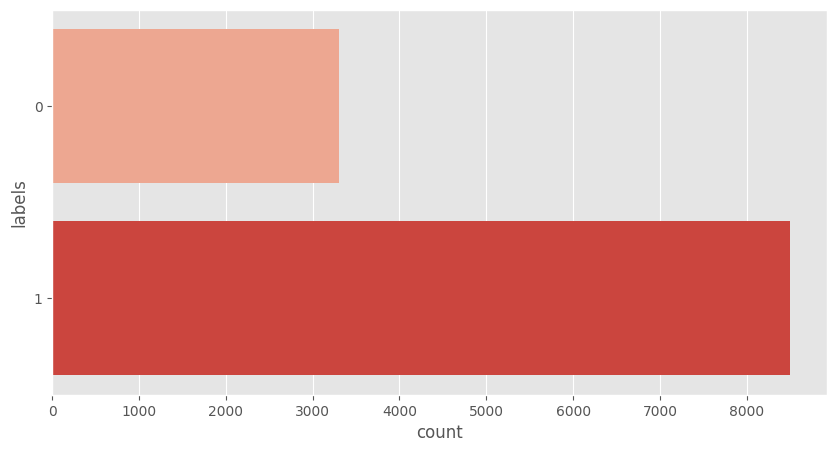

In [ ]:
plt.subplots(figsize = (10, 5))
sns.countplot(y = df['labels'], palette='Reds')
plt.show()

  0%|          | 0/11807 [00:00<?, ?it/s]

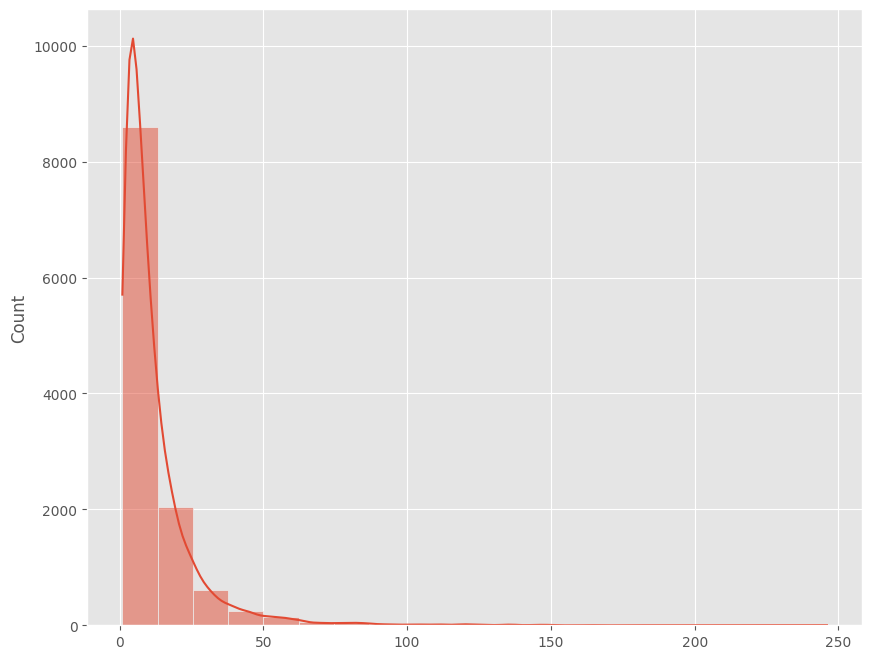

In [ ]:
length = []
for txt in tqdm(df['Processed Text'].values):
  length.append(len(txt.split(" ")))

plt.subplots(figsize = (10,8))
sns.histplot(length, bins = 20, kde=True)
plt.show()

In [ ]:
X, y = df['Processed Text'].values, df['labels'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

X_train.shape, X_val.shape, y_train.shape, y_val.shape


((10626,), (1181,), (10626,), (1181,))

In [ ]:
BATCH_SIZE = 8

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
train_encodings = tokenizer(list(X_train), padding = "max_length", truncation=True)
val_encodings = tokenizer(list(X_val), padding = "max_length", truncation=True)

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
)).batch(BATCH_SIZE)


val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val
)).batch(BATCH_SIZE)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained(
    "bert-base-cased",
    num_labels = num_classes,
    label2id = label2id,
    id2label = id2label
)

model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5),
    metrics = ["accuracy"]
)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 108311810 (413.18 MB)
Trainable params: 108311810 (413.18 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
EPOCHS = 3

history = model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = EPOCHS
)

Epoch 1/3
1329/1329 [==============================] - 1349s 970ms/step - loss: 0.4579 - accuracy: 0.7817 - val_loss: 0.3643 - val_accuracy: 0.8256
Epoch 2/3
1329/1329 [==============================] - 1290s 971ms/step - loss: 0.3191 - accuracy: 0.8560 - val_loss: 0.2937 - val_accuracy: 0.8603
Epoch 3/3
1329/1329 [==============================] - 1289s 970ms/step - loss: 0.2652 - accuracy: 0.8838 - val_loss: 0.2815 - val_accuracy: 0.8772


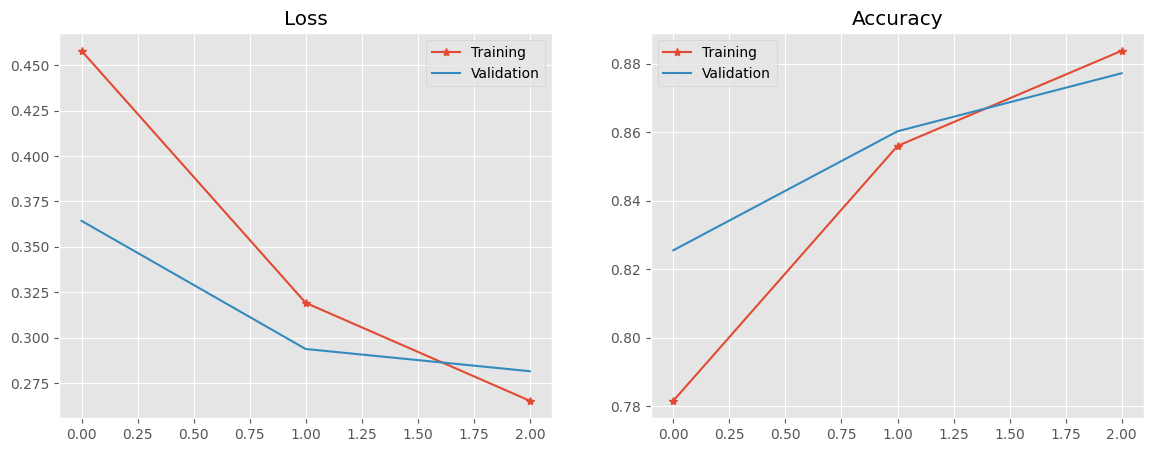

In [ ]:
plt.figure(figsize = (14, 5))

plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(history.history['loss'], marker = '*', label = 'Training')
plt.plot(history.history['val_loss'], label = 'Validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], marker = '*', label = 'Training')
plt.plot(history.history['val_accuracy'], label = 'Validation')
plt.legend()

In [ ]:
out = model.predict(val_dataset)
pred = np.argmax(out[0], axis = 1)
pred

148/148 [==============================] - 52s 332ms/step


array([0, 1, 0, ..., 1, 1, 1])

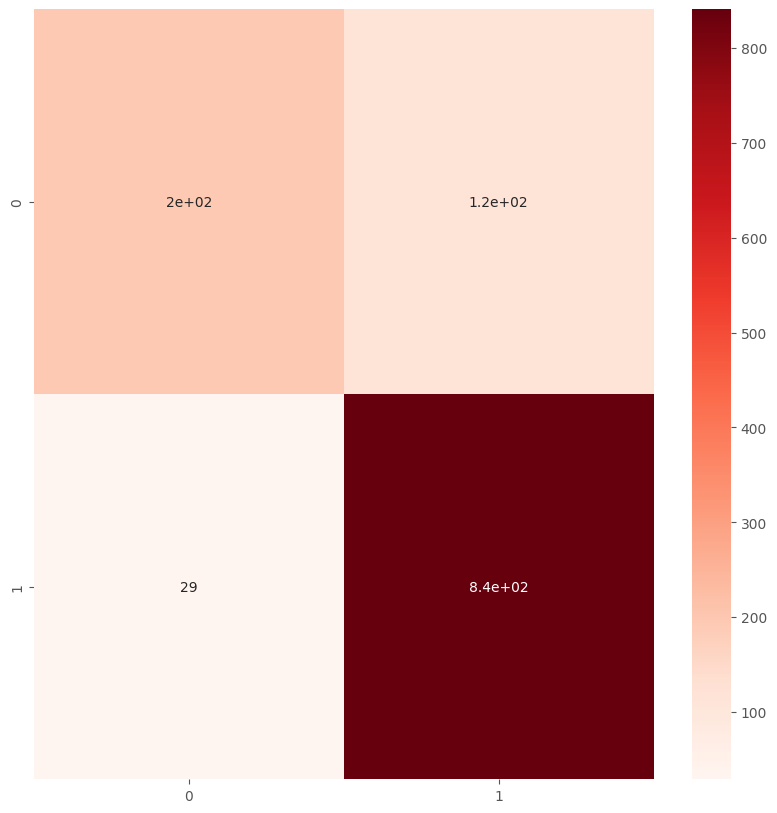

In [ ]:
cm = confusion_matrix(y_val, pred)
plt.subplots(figsize = (10, 10))
sns.heatmap(cm, annot = True, cmap='Reds')
plt.show()

In [ ]:
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, top_k = num_classes)
text = " এটা একটা ভালো সিনেমা"
pred = pipe(text)

print(pred[0])

[{'label': 'Positive', 'score': 0.6958863735198975}, {'label': 'Negative', 'score': 0.3041136860847473}]
